# AI2S Deep Learning Day - Beginners notebook
<sub>Alessio Ansuini, AREA Research and Technology</sub>

<sub>Andrea Gasparin and Marco Zullich, Artificial Intelligence Student Society</sub>


## Pytorch

PyTorch is a Python library offering extensive support for the construction of deep Neural Networks (NNs).

One of the main characteristics of PyTorch is that it operates with **Tensors**, as they provide a significative speed up of the computations.

For the scope of this introduction we can simply think at Tensors as arrays, with all the relative operations preserved as we can see in the following example.






In [1]:
import numpy as np
import torch

tensor_A = torch.tensor([1,1,1])
array_A  = np.array([1,1,1])
print(tensor_A)
print(array_A)
print( 2 * tensor_A )
print( 2 * array_A )


tensor([1, 1, 1])
[1 1 1]
tensor([2, 2, 2])
[2 2 2]


## The images representation

In our context, we will work with black and white images. They are represented as matrices containing numbers.

The numbers will go from 0 (white) to the max value (black) including all the grey scale spectrum.



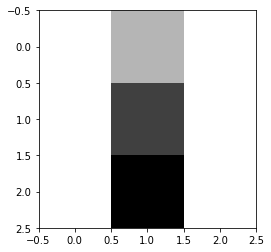

In [2]:
central_vertical_line = torch.tensor([[  0,  4,  0],
                                      [  0,  8,  0],
                                      [  0, 10,  0]])
import matplotlib.pyplot as plt #plots and image viewer module
plt.imshow(central_vertical_line, cmap="Greys")

## Handwritten digit recognition (MNIST dataset)

In this notebook, we'll train a simple fully-connected NN for the classification of the MNIST dataset. 
The MNIST (*modified National Institute of Standards and Technology database*) is a collection of 28x28 pixels black and white images containing handwritten digits. Let's see an example:




In [3]:
import torchvision #the module where is stored the dataset

#to improve training efficiency, data are first normalised. The "transform" method will do the job for us
transform = torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    ])

trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)



**trainset.data** contains the images, represented as 28x28 matrixes of float numbers

**trainset.target** contains the labels, so the numbers represented in the images

In [4]:
print("trainset.data[0] is the first image; its size is:", trainset.data[0].shape)
print("the digit represented is the number: ", trainset.targets[0])

# if we have a tensor composed of a single scalar, we can extract the scalar via tensor.item()
print("scalar representation: ", trainset.targets[0].item())

trainset.data[0] is the first image; its size is: torch.Size([28, 28])
the digit represented is the number:  tensor(5)
scalar representation:  5


Let's see that the image actually shows the number 5

tensor([  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253,
        253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,   0,   0],
       dtype=torch.uint8)


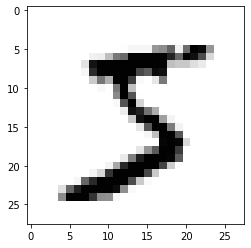

In [5]:
print(trainset.data[0][6])
plt.imshow(trainset.data[0], cmap='Greys')

### THE TRAINING

First we need to separate the images and the labels







In [6]:
train_imgs = trainset.data
train_labels = trainset.targets
test_imgs = testset.data
test_labels = testset.targets

### Flatten the image

To simplify the network flow, images are initially flattened, meaning that the corresponding matrix will be transformed in a single longer row array:

In [7]:
central_vertical_line_flattened = central_vertical_line.flatten()
print("initial matrix:\n",central_vertical_line)
print("\nmatrix flattened:\n",central_vertical_line_flattened)
print("\nmatrix shape:",central_vertical_line.shape, "   flattened shape:", central_vertical_line_flattened.shape)

initial matrix:
 tensor([[ 0,  4,  0],
        [ 0,  8,  0],
        [ 0, 10,  0]])

matrix flattened:
 tensor([ 0,  4,  0,  0,  8,  0,  0, 10,  0])

matrix shape: torch.Size([3, 3])    flattened shape: torch.Size([9])


### Creating the NN

We create the NN as in the image below:
* the **input layer** has 784 neurons: this as the images have 28x28=784 numbers;
* there are three **hidden layers**: the first one has 16 neurons, the second one has 32, the first one has 16 again;
* the **output layer** has 10 neurons, one per class.

The NN can be easily created using the `torch.nn.Sequential` method, which allows for the construction of the NN by pipelining the building blocks in a list and passing it to the Sequential constructor.

We pass to Sequential the following elements:
* we start with a `Flatten()` module since we need to flatten the 2D 28x28 images into the 784 elements 1D array
* we alternate `Linear` layers (fully-connected layers) with `ReLU` modules (Rectified Linear Unit) activation functions
* we conclude with a `Linear` layer withoud activation function: this will output, for each image, an array of 10 scalars, each one indicating the "confidence" that the network has in assigning the input image to the corresponding class. We'll assign the image to the class having the highest confidence.

After this, the architecture of the NN is complete! We will then focus on telling Python how to train this NN.


In [8]:
from torch import nn

inputDimension = 784
outputDimension = 10 # the number of classes - 10 digits from 0 to 9
layersWidth = 16 


network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputDimension, layersWidth),
    nn.ReLU(),
    nn.Linear(layersWidth, layersWidth*2),
    nn.ReLU(),
    nn.Linear(layersWidth*2, layersWidth),
    nn.ReLU(),
    nn.Linear(layersWidth, outputDimension),
)


### NN training

We'll use vanilla mini-batch Stochastic Gradient Descent (SGD) with a learning rate of *learningRate* (you chose!!!) as the optimizer.

We'll create mini-batches of size *batchSize* (i.e., we'll have 60000/*batchSize*=600 mini-batches containing our data) for the training.

We'll train the NN for *epochs* epochs, each epoch indicating how many times the NN "sees" the whole dataset during training.

The loss function we'll use is the **categorical cross-entropy** (particularly useful for non-binary classification problems) and we'll also evaluate the network on its **accuracy** (i.e., images correctly classified divided by total images).


### *learningRate*, *batchSize*, and  *epochs* are parameters you can play with, let's see haw you can improve the accuracy!!!

In [9]:
#hyper parameters

batchSize = 100
learningRate = 0.1
epochs = 3

In order to pass our data to the network, we'll make use of DataLoaders: they take care of subdividing the dataset into mini-batches, applying the requested transformations, and optionally re-shuffling them at the beginning of each new epoch.

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

We also provide a function to compute the accuracy of the nn given its outputs and the true values of the images they are trying to classify

In [11]:
def calculate_accuracy(nn_output, true_values):
    class_prediction = nn_output.topk(1).indices.flatten()
    match = (class_prediction == true_values)
    correctly_classified = match.sum().item()
    accuracy = correctly_classified / nn_output.size(0)
    return accuracy

Let's check that it works for a fictitious batch of 4 images and 3 classes.

A NN output in this case will be a matrix of shape 4x3, each row holding the probability that the model assigns the corresponding image to the corresponding class.

We create a fake ground truth s.t. the NN assigns correctly the first 3 images: the corresponding accuracy should then be 3/4=0.75


### Here the actual traininig

In [12]:
lossValues = []  #to store the loss value trand during the training (we want it to DECREASE as much as possible)
accuracy = []   #to store the accuracy  trand during the training (we want it to INCREASE as much as possible)
lossFunction = torch.nn.CrossEntropyLoss()  #the error function the nn is trying to minimise



network.train()  #this tells our nn that it is in training mode. 
optimizer = torch.optim.SGD(network.parameters(), lr=learningRate)  #the kind of optimiser we want of our nn to use

# MAIN LOOP: one iteration for each epoch
for e in range(epochs):
    # INNER LOOP: one for each MINI-BATCH
    for i, (imgs, ground_truth) in enumerate(trainloader): #range(num_of_batches):

      optimizer.zero_grad() # VERY TECHNICAL needed in order NOT to accumulate gradients on top of the previous epochs
      
      predictions = network(imgs)

      loss = lossFunction(predictions, ground_truth)
      
      loss.backward()
      optimizer.step()
      
      accuracy_batch = calculate_accuracy(predictions, ground_truth)

      lossValues.append(loss.item())
      accuracy.append(accuracy_batch)
      
      # Every 200 iterations, we print the status of loss and accuracy
      if (i+1)%200 == 0:
        print(f"***Epoch {e+1} | Iteration {i+1} | Mini-batch loss {loss.item()} | Mini-batch accuracy {accuracy_batch}")

***Epoch 1 | Iteration 200 | Mini-batch loss 0.4923737049102783 | Mini-batch accuracy 0.88
***Epoch 1 | Iteration 400 | Mini-batch loss 0.3405783176422119 | Mini-batch accuracy 0.91
***Epoch 1 | Iteration 600 | Mini-batch loss 0.388040155172348 | Mini-batch accuracy 0.9
***Epoch 2 | Iteration 200 | Mini-batch loss 0.5329132080078125 | Mini-batch accuracy 0.83
***Epoch 2 | Iteration 400 | Mini-batch loss 0.17529051005840302 | Mini-batch accuracy 0.93
***Epoch 2 | Iteration 600 | Mini-batch loss 0.2503686249256134 | Mini-batch accuracy 0.91
***Epoch 3 | Iteration 200 | Mini-batch loss 0.17247360944747925 | Mini-batch accuracy 0.93
***Epoch 3 | Iteration 400 | Mini-batch loss 0.14847934246063232 | Mini-batch accuracy 0.95
***Epoch 3 | Iteration 600 | Mini-batch loss 0.15340544283390045 | Mini-batch accuracy 0.95


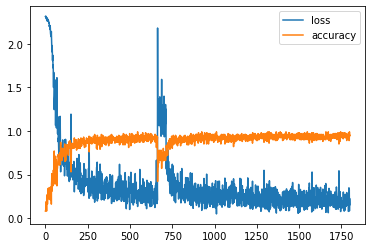

In [13]:
# Let us draw the charts for loss and accuracy for each training iteration
plt.plot(lossValues, label="loss")
plt.plot(accuracy, label="accuracy")
plt.legend()

# Check yourself

Here we provide a function to pick a few images from the test set and check if the network classifies them properly

In [14]:
def classify():
  for i in range(5):
    num = np.random.randint(0,test_imgs.shape[0])
    network.eval()
    plt.imshow(test_imgs[num])
    plt.show()
    print("Our network classifies this image as: ", network(test_imgs[num:num+1].float()).topk(1).indices.flatten().item())
    print("The true value is: ", test_labels[num:num+1].item())
    print("\n\n")

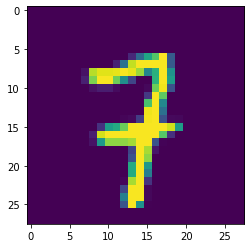

Our network classifies this image as:  7
The true value is:  7





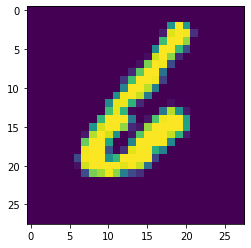

Our network classifies this image as:  6
The true value is:  6





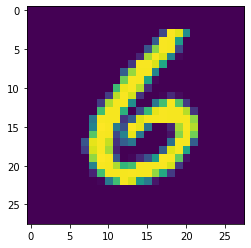

Our network classifies this image as:  6
The true value is:  6





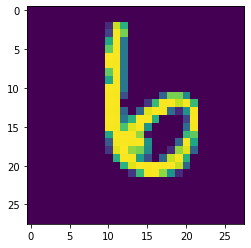

Our network classifies this image as:  6
The true value is:  6





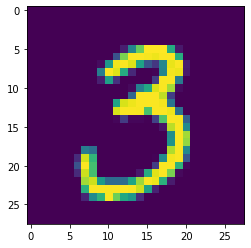

Our network classifies this image as:  3
The true value is:  3





In [15]:
classify()